# MSc Data Science: playing with Tensorflow probability 

TF Probability is a library that allows to use probabilisitic/statistical tools within TF. It will be very useful for us, in particular to code VAEs.

Here, I'll simply show you the ropes of TF Probability. This tutorial is inspired by [this one](https://github.com/tensorflow/probability/blob/master/tensorflow_probability/examples/jupyter_notebooks/TensorFlow_Distributions_Tutorial.ipynb).

Pytorch also has something very similar called [Pytorch distributions](https://pytorch.org/docs/stable/distributions.html).

# Loading Tensorflow probability

In [1]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

In [2]:
import tensorflow as tf
import tensorflow_probability as tfp
import matplotlib.pyplot as plt
import numpy as np

tfd = tfp.distributions

2022-10-25 15:01:22.954969: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-25 15:01:23.150714: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-11.0/include:/usr/local/cuda-11.0/lib64:
2022-10-25 15:01:23.150736: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-10-25 15:01:23.180171: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been regi

# Univariate distributions

TFP allows you to define **probability distributions** as Python objects that you can use for example to


*   sample
*   compute densities



Let us start simple, with a univariate Gaussian.

In [4]:
gaussian = tfd.Normal(loc=0., scale=1.)
type(gaussian)

tensorflow_probability.python.distributions.normal.Normal

In [5]:
gaussian.sample(1) # returns 1 sample

<tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.5666902], dtype=float32)>

In [6]:
gaussian.sample(1).numpy() # returns 1 sample in numpy

array([-0.6991901], dtype=float32)

In [7]:
gaussian.sample(10) # returns 10 samples

<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([-1.2107042 , -0.6136168 , -0.7356    , -0.7412504 , -1.0443474 ,
       -1.0004816 , -0.15291743, -0.23181416,  0.55102026, -1.4102217 ],
      dtype=float32)>

In [8]:
gaussian.mean().numpy()

0.0

In [9]:
x = 3

gaussian.prob(x) # compute the density of x

<tf.Tensor: shape=(), dtype=float32, numpy=0.004431848>

In [10]:
x = 3

# compute the log  of density of x (useful to compute log-likelihoods!)
gaussian.log_prob(x)

<tf.Tensor: shape=(), dtype=float32, numpy=-5.4189386>

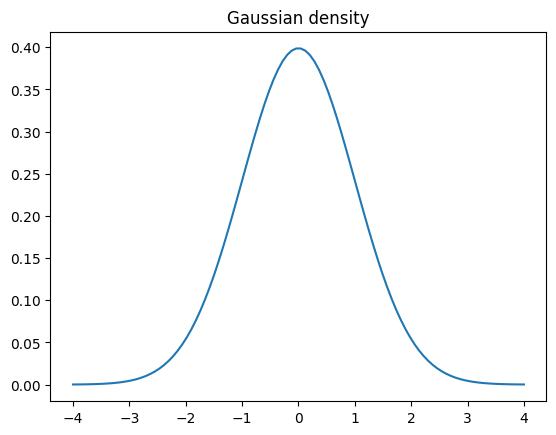

In [11]:
points = np.linspace(-4,4,100)

plt.plot(points, gaussian.prob(points))
plt.title("Gaussian density")
plt.show()

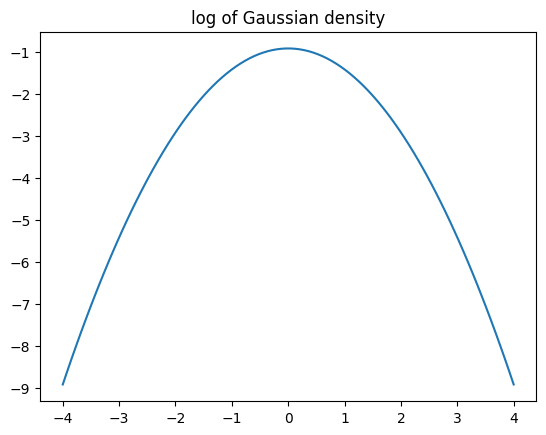

In [12]:
points = np.linspace(-4,4,100)

plt.plot(points, gaussian.log_prob(points))
plt.title("log of Gaussian density")
plt.show()

Many more classical distributions are implemented, like the Student's t:

In [13]:
student = tfd.StudentT(loc=0., scale=1.,df=2)

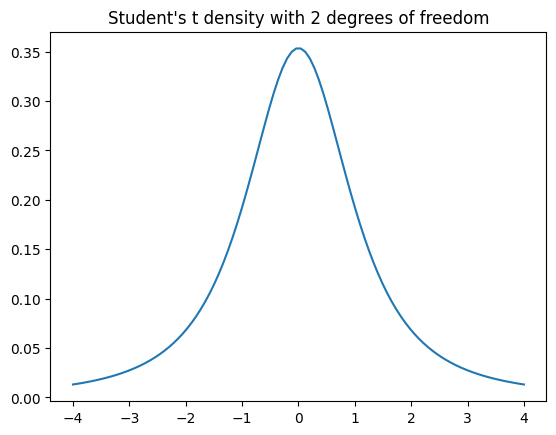

In [14]:
points = np.linspace(-4,4,100)

plt.plot(points, student.prob(points))
plt.title("Student's t density with 2 degrees of freedom")
plt.show()

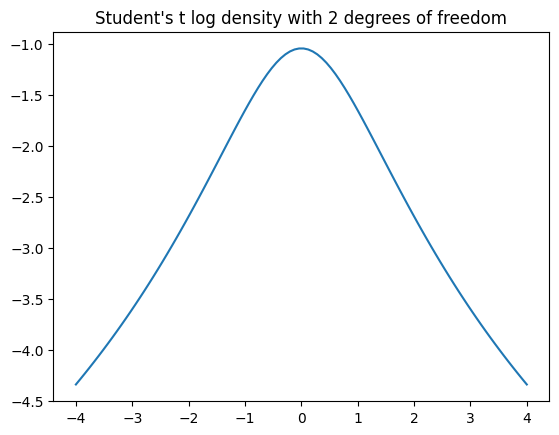

In [15]:
points = np.linspace(-4,4,100)

plt.plot(points, student.log_prob(points))
plt.title("Student's t log density with 2 degrees of freedom")
plt.show()

We can also use discrete distributions, like the Bernoullil:

In [16]:
bern = tfd.Bernoulli(probs = 0.2)

In [17]:
bern.sample(10)

<tf.Tensor: shape=(10,), dtype=int32, numpy=array([1, 0, 0, 0, 0, 1, 1, 1, 1, 0], dtype=int32)>

# Creating several univariate distributions

Often, in machine learning, we have to deal with a lot of similar distributions. For example, if we want to learn a regression model, we want to define $n$ conditional distributions $p(y|\mathbf{x}_1),...,p(y|\mathbf{x}_n)$ with a similar structure.

Feeding a bunch of parameters to the function that creates a distribution allows you to create a bunch of distributions at the same time.

In [18]:
multiple_bernoullis = tfd.Bernoulli(probs=[.3, .5, .7])
multiple_bernoullis

<tfp.distributions.Bernoulli 'Bernoulli' batch_shape=[3] event_shape=[] dtype=int32>

In [19]:
multiple_bernoullis.sample(5)

<tf.Tensor: shape=(5, 3), dtype=int32, numpy=
array([[0, 1, 0],
       [0, 1, 1],
       [0, 1, 1],
       [0, 0, 1],
       [1, 1, 0]], dtype=int32)>

The **batch shape** of [3] indicates that `multiple_Bernoullis` is constitued of a **batch of 3 Bernoulli distributions**.

The **event shape** of [] indicates that all these 3 distributions are univariate.

**How can we create multivariate distributions?** There are ways to create popular distributions directly (see e.g. `tfd.MultivariateNormalFullCovariance`), but here, we will focus on how to create **products of distributions** (aka fully factorised distributions).






# Creating fully factorised distributions


Let's say we have $K$ univariate distributions $p(x_1),...,p(x_K)$. A way to define a distribution over $K$-dimensional vector $\mathbf{x} = (x_1,...,x_K)$ is to consider the product
$$p ( \mathbf{x}) = \prod_{k=1}^K  p(x_k).$$

This means that the coordinates of $\mathbf{x}$ will be **independent**.

Fully factorised distributions, because they are convenient ways to deal with high-dimensional data, are everywhere in machine learning! For example in VAEs...

Using TFP, it's rather easy to define fully factorised distributions, via the function `tfd.Independent`. The idea is to first define a bunch of distributions (like we saw before), and then combine them.

In [20]:
multiple_bernoullis

<tfp.distributions.Bernoulli 'Bernoulli' batch_shape=[3] event_shape=[] dtype=int32>

In [22]:
prod_multiple_bernoullis = tfd.Independent(multiple_bernoullis, reinterpreted_batch_ndims=1)
prod_multiple_bernoullis

<tfp.distributions.Independent 'IndependentBernoulli' batch_shape=[] event_shape=[3] dtype=int32>

Now, the batch shape is [], which indicates that we have a **single distribution**, but the event shape is [3], which indicates that this single distribution is 3-dimensional!

In [23]:
prod_multiple_bernoullis.sample(5)

<tf.Tensor: shape=(5, 3), dtype=int32, numpy=
array([[1, 0, 0],
       [0, 0, 1],
       [0, 1, 1],
       [0, 1, 1],
       [1, 1, 1]], dtype=int32)>

When we sample, we hardly see the difference...

But computing the density is quite different!

In [25]:
multiple_bernoullis.prob([0,0,1])

<tf.Tensor: shape=(3,), dtype=float32, numpy=array([0.7, 0.5, 0.7], dtype=float32)>

In [26]:
prod_multiple_bernoullis.prob([0,0,1])

<tf.Tensor: shape=(), dtype=float32, numpy=0.24500002>

What's the difference? How are these results related?

For more details on this, see [this tutorial](https://github.com/tensorflow/probability/blob/master/tensorflow_probability/examples/jupyter_notebooks/TensorFlow_Distributions_Tutorial.ipynb) (that I used to write mine), or [this one](https://github.com/tensorflow/probability/blob/master/tensorflow_probability/examples/jupyter_notebooks/Understanding_TensorFlow_Distributions_Shapes.ipynb) (that is more about the different shapes).